<a href="https://colab.research.google.com/github/rparra09/rparra09.github.io/blob/rparra09/Climate_Data_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting using XGBoost**
# This notebook leverages XGBoost, a tree ensemble model consisting of a set of classification and regression trees (CART), to forecast climate data. This was my submission to the Women in Data Science (WiDS) Datathon 2023 where the data was provided by WiDS.


#**Step 1: Import Packages**
Load Necessary packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install --upgrade category_encoders

## Performance Measurement packages
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
##Pyplot styling
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

## function to calculate MSE
def mean_squared_error(y_true, y_pred):
    """Calculates MSE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.square(np.abs((y_true - y_pred))).mean()
## allow Colab to pull data from GDrive
from google.colab import drive
drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 1.7 MB/s eta 0:00:00
Mounted at /content/drive/


#**Step 2: Load Data**
The data comes from WiDS Datathon 2023 Competition page: https://www.kaggle.com/competitions/widsdatathon2023

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/datasources/WiDS_Datathon_2023/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/datasources/WiDS_Datathon_2023/train_data.csv')
Target = 'contest-tmp2m-14d__tmp2m'

#**Step 3: EDA and Cleaning**
Define a funtion, check_null_index, to identify null values.

In [ ]:
## function to check for columns with Null values
def check_null_index(df):
    null_check_df = df.isnull().any()
    non_null_index_list = list((null_check_df[null_check_df==False]).index)
    null_index_list = list((null_check_df[null_check_df==True]).index)
    print(non_null_index_list)
    print(null_index_list)

    return null_index_list

train_null = check_null_index(train_df)

['index', 'lat', 'lon', 'startdate', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'contest-rhum-sig995-14d__rhum', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-56w__ccsm40', 'nmme0-

Import SimpleImputer. Define second function, impute_number_col, to replace null values with a median value for that column.

In [ ]:
## function to insert a medin value in null cells
from sklearn.impute import SimpleImputer
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
def impute_number_col(df):
    null_col = ['nmme0-tmp2m-34w__ccsm30',
    'nmme-tmp2m-56w__ccsm3',
    'nmme-prate-34w__ccsm3',
    'nmme0-prate-56w__ccsm30',
    'nmme0-prate-34w__ccsm30',
    'nmme-prate-56w__ccsm3',
    'nmme-tmp2m-34w__ccsm3',
    'ccsm30',
    'nmme-tmp2m-56w__cfsv2']
    number_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    fixed_column_df = number_imputer.fit_transform(df[null_col])
    df[null_col] = fixed_column_df
    return df

Import encoding package. Define a third function, Cleaning, to concatenate latitude/longitude into a single column, and year/month/day into startdate

In [ ]:
## encoding Categorical Variables, transforming latitude/longitude into a numerical value,
import category_encoders as ce

def Cleaning(data,k):

    encoder = ce.BinaryEncoder(cols=['climateregions__climateregion'], return_df=True)
    data = encoder.fit_transform(data)

    data['location'] = data.groupby(['lat','lon']).ngroup()

    data['startdate'] = pd.to_datetime(data['startdate'])
    data['year'] = data['startdate'].dt.year
    data['month'] = data['startdate'].dt.month
    data['day'] = data['startdate'].dt.dayofyear

    data = data.sort_values(by=['location', 'startdate']).ffill()

    data.drop(columns=['lat', 'lon', 'index'], inplace=True)

    return data

Use Cleaning function on both train and test datasets

In [ ]:
train_data = Cleaning(train_df,1)
test_data = Cleaning(test_df,2)

In [ ]:
## Drop startdate column
train_data.drop(columns=['startdate'], inplace=True)
test_data.drop(columns=['startdate'], inplace=True)

Double check no null vallues are present in datasets to get more accurate predictions

In [ ]:
#Checking for null values again
round(train_data.isnull().sum()*100/len(train_data),2).sort_values(ascending=False)[:10]

contest-pevpr-sfc-gauss-14d__pevpr    0.0
wind-hgt-500-2010-7                   0.0
sst-2010-4                            0.0
sst-2010-5                            0.0
sst-2010-6                            0.0
sst-2010-7                            0.0
sst-2010-8                            0.0
sst-2010-9                            0.0
sst-2010-10                           0.0
wind-hgt-500-2010-1                   0.0
dtype: float64

#**Step 5: Plotting Data**
Easy visualizations to view overall trends/patterns in data over time, eye check for any anomalies

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

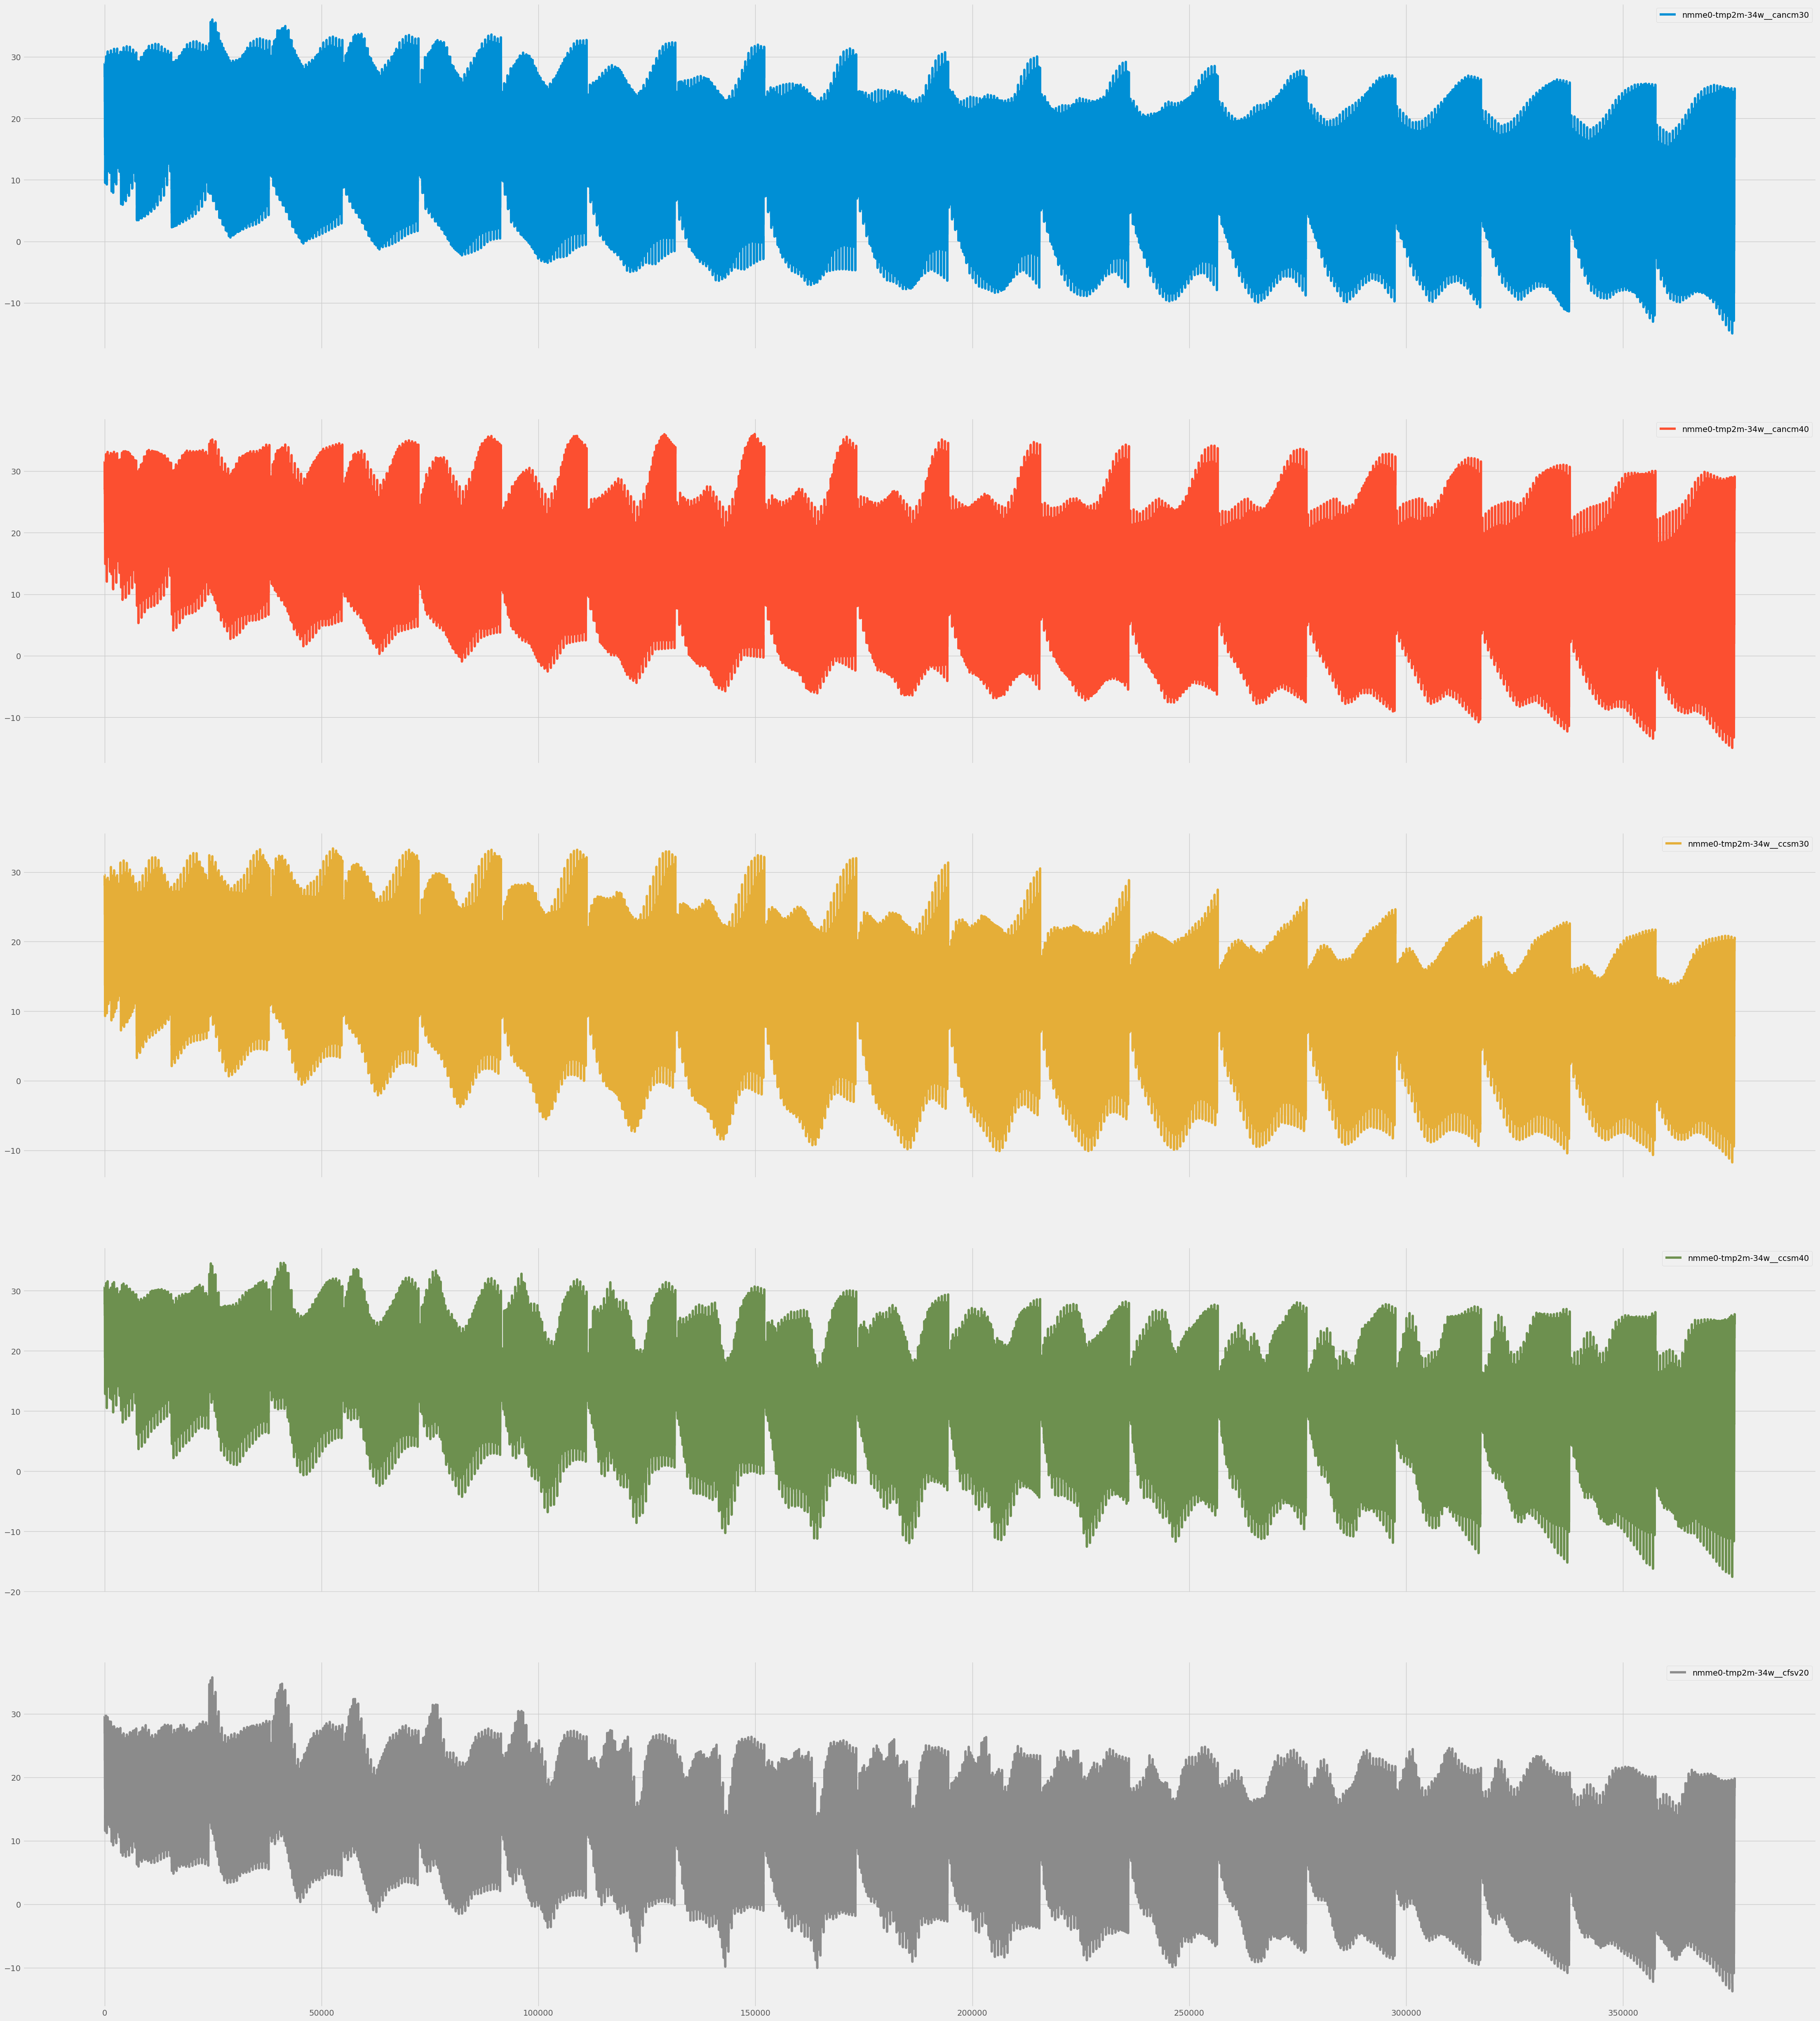

In [ ]:
# graphs of longitudinal wind at 250 millibars
t1=train_data.loc[:, train_data.columns.str.startswith('nmme0-tmp2m-34w__c')]
t1.plot(subplots=True, figsize=(50,60))

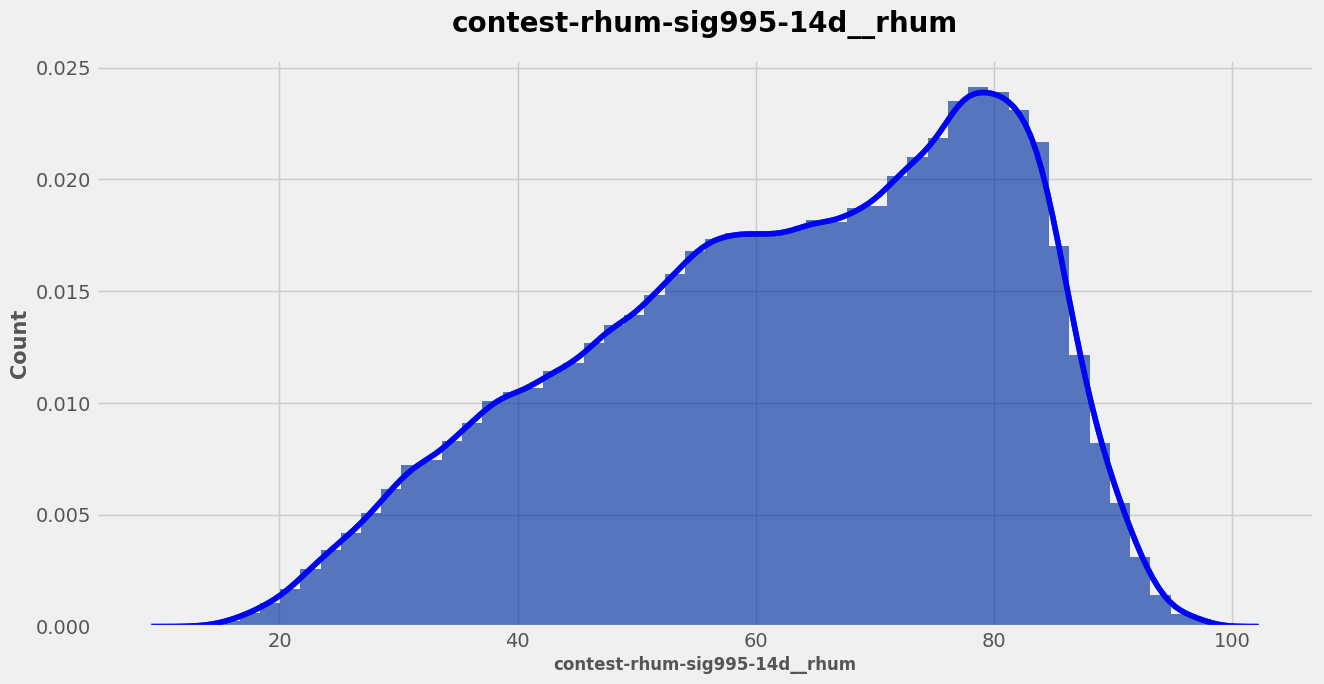

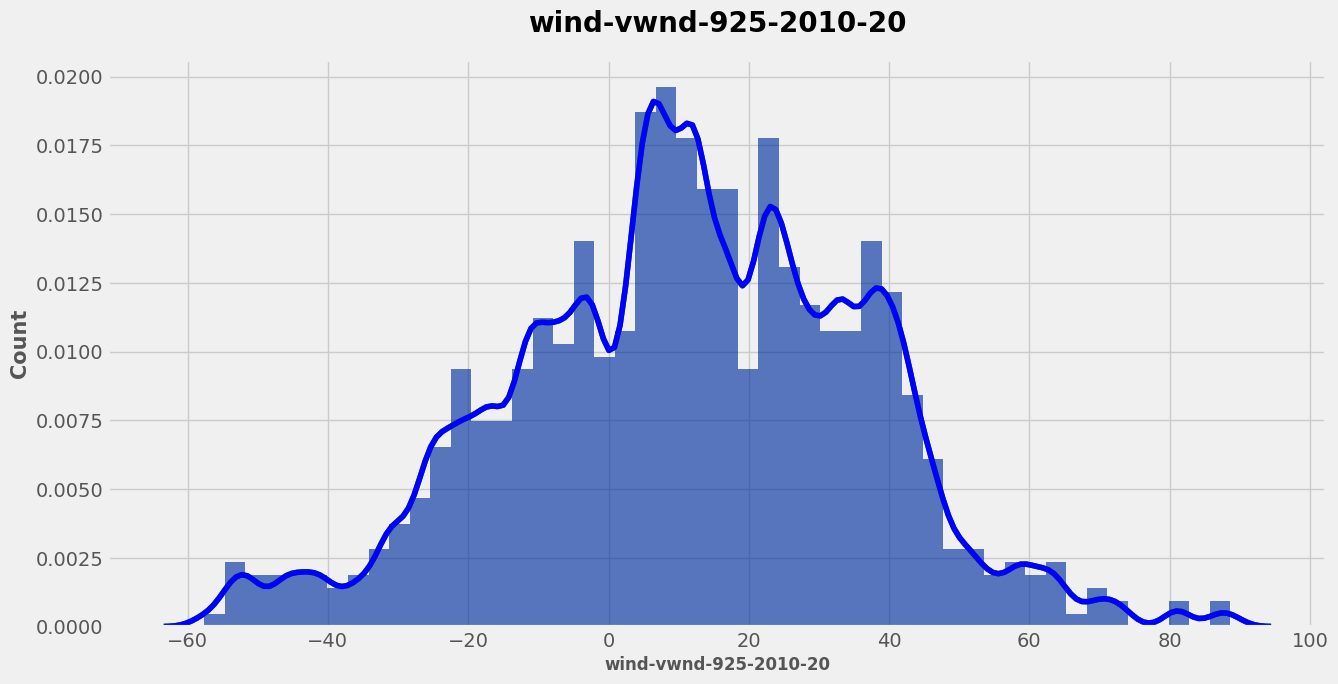

In [ ]:
##
def plot_distribution(var):
    plt.subplots(figsize=(14,7))
    sns.distplot(x=train_data[var], color='green', kde=True)
    sns.distplot(x=test_data[var], color='blue', kde=True)
    plt.title(var, weight="bold",fontsize=20, pad=20)
    plt.ylabel("Count", weight="bold", fontsize=15)
    plt.xlabel(var, weight="bold", fontsize=12)
    plt.show()
plot_distribution("contest-rhum-sig995-14d__rhum")
plot_distribution("wind-vwnd-925-2010-20")


#**Step 5: Set Target**

In [ ]:
Target="contest-tmp2m-14d__tmp2m"
y=train_data[Target]
x=train_data.drop([Target],axis=1)

#**Step 6: Split Train Data Set**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#**Step 7: Import and run XGBoost**

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       tree_method = 'hist',
                       n_estimators=10000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01, gpu_id=0)


# Run XGBoost Model on Split Dataset

In [ ]:
bst = reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[15:33:42] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[0]	validation_0-rmse:14.91010	validation_1-rmse:14.88726
[100]	validation_0-rmse:6.03692	validation_1-rmse:6.03024
[200]	validation_0-rmse:3.05087	validation_1-rmse:3.05011
[300]	validation_0-rmse:2.12953	validation_1-rmse:2.13068
[400]	validation_0-rmse:1.82163	validation_1-rmse:1.82302
[500]	validation_0-rmse:1.68246	validation_1-rmse:1.68357
[600]	validation_0-rmse:1.59253	validation_1-rmse:1.59388
[700]	validation_0-rmse:1.52033	validation_1-rmse:1.52177
[800]	validation_0-rmse:1.46429	validation_1-rmse:1.46616
[900]	validation_0-rmse:1.42084	validation_1-rmse:1.42330
[1000]	validation_0-rmse:1.38630	validation_1-rmse:1.38927
[1100]	validation_0-rmse:1.35572	validation_1-rmse:1.35912
[1200]	validation_0-rmse:1.32586	validation_1-rmse:1.32970
[1300]	validation_0-rmse:1.29848	validation_1-rmse:1.30274
[1400]	validation_0-rmse:1.27412	validation_1-rmse:1.27883
[1500]	validation_0-rmse:1.25122	v

Saved forecasting results as a checkpoint

In [ ]:
bst.save_model("/content/drive/MyDrive/datasources/WiDS_Datathon_2023/model2.bst")

# Ran Model previously and saved, now will load saved model as model_xgb

In [ ]:
model_xgb = xgb.Booster()
model_xgb.load_model("/content/drive/MyDrive/datasources/WiDS_Datathon_2023/model.bst")

[21:26:32] WARNING: ../src/learner.cc:1098: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [ ]:
from xgboost import XGBClassifier, plot_importance
fit = XGBClassifier().fit(x,y)
plot_importance(fit)

ValueError: ignored

In [ ]:
X_test_prediction = reg.predict(X_test)

NotFittedError: ignored

#**Step 8: RMSE Score on Test Dataset**

In [ ]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(y_test, X_test_prediction))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.75


#**Step 9: Drop Target from Test Dataset and run prediction**

In [ ]:
test_data2 = test_data.drop('contest-tmp2m-14d__tmp2m', axis=1)

In [ ]:
predictions=reg.predict(test_data2)


Calculate errors on prediction

In [ ]:
X_test_error = np.abs(y_test - X_test_prediction)
X_test_error.sort_values(ascending=False).head(10)

298170    6.751570
298172    6.688679
298168    6.159946
298174    5.727584
298158    5.551724
298178    5.527012
298176    5.491930
298156    5.463638
298177    5.458351
298157    5.411867
Name: contest-tmp2m-14d__tmp2m, dtype: float64

#**Step 10: Predictions Forecasting**

Save dataset Prediction Forecasting numbers as Target column

In [ ]:
test_data2[Target] = predictions

Create index for predictions numbers and save in requested formate per Datathon rules

In [ ]:
start_index = 375734
end_index = 751468

index = pd.DataFrame(data=predictions, index=range(start_index, end_index))

print(index)

                0
375734  29.161377
375735  28.877758
375736  28.704758
375737  28.711523
375738  28.710821
...           ...
751463  17.046268
751464  16.787083
751465  16.682892
751466  15.900441
751467  15.042767

[375734 rows x 1 columns]


Save Predicitons to a csv file, then separately uploaded into the Datathon submissions site

In [ ]:
#submission = pd.DataFrame({'Target': predictions, 'index': index})
#submission.to_csv('/content/drive/MyDrive/datasources/WiDS_Datathon_2023/submission_xgboost.csv', index=False)

In [ ]:
submission2 = index

#**Step 11: Plot Predictions VS Target Values**

RMSE Score on Test set: 0.75


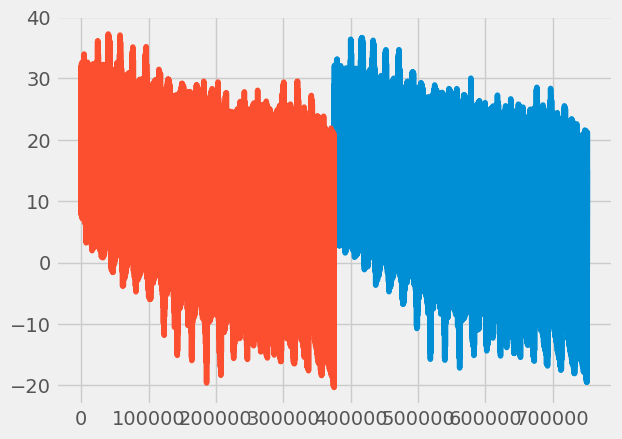

In [ ]:
#test_org[[Target,"index"]].to_csv("/content/drive/MyDrive/datasources/WiDS_Datathon_2023/xgboost_submission.csv",index=False)


plt.plot(submission2)
#plt.plot(test_data['contest-tmp2m-14d__tmp2m'])

print(f'RMSE Score on Test set: {score:0.2f}')
plt.plot(test_data['contest-tmp2m-14d__tmp2m'])


Predictions are in line with general trend of Target values. I submitted the results into the datathon and received the best score within our team, All That Data.